In [1]:
!pip install stellargraph

  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.0
    Uninstalling numpy-1.18.0:
      Successfully uninstalled numpy-1.18.0
  Rolling back uninstall of numpy
  Moving to /home/jovyan/.local/bin/f2py
   from /tmp/pip-uninstall-fxl1gxtp/f2py
  Moving to /home/jovyan/.local/bin/f2py3
   from /tmp/pip-uninstall-fxl1gxtp/f2py3
  Moving to /home/jovyan/.local/bin/f2py3.7
   from /tmp/pip-uninstall-fxl1gxtp/f2py3.7
  Moving to /home/jovyan/.local/lib/python3.7/site-packages/numpy-1.18.0.dist-info/
   from /home/jovyan/.local/lib/python3.7/site-packages/~umpy-1.18.0.dist-info
  Moving to /home/jovyan/.local/lib/python3.7/site-packages/numpy/
   from /home/jovyan/.local/lib/python3.7/site-packages/~-mpy
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/home/user/conda/lib/python3.7/site-packages/numpy/_distributor_init.py'
Consider using the `--user` option or 

In [3]:
!pip install networkx

You should consider upgrading via the '/home/user/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm

pd.set_option('display.max_columns', 500)
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split
import networkx as nx
from stellargraph.mapper import GraphWaveGenerator
from stellargraph import StellarGraph
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigs
import tensorflow as tf
from tensorflow.keras import backend as K


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

## DATASET PROCESING

Загружаем граф:

In [2]:
graph = pd.read_csv("duo_edge.csv")

In [3]:
graph.dropna(inplace=True)

In [4]:
graph['adjacent'] = graph['adjacent'].astype("str")

Генерируем edge list:

In [6]:
def get_index_tuples(df):
    lst = []
    for i in tqdm(range(len(df))):
        tmp = df['adjacent'].iloc[i].split(',')
        for edge in tmp:
            lst.append([i, int(edge)])
            
    return lst
lst = get_index_tuples(graph)
lst = pd.DataFrame(lst)

100%|██████████| 206438/206438 [00:02<00:00, 102869.09it/s]


In [7]:
edge_data = pd.DataFrame(
    {
        "source": list(lst[0]),
        "target": list(lst[1])
    }
)

In [9]:
node_data = graph.drop(["edge_id", "adjacent", "style_<pandas.io.formats.style.Styler object at 0x000001B5DF375370>"], axis = 1)

In [8]:
node_data = pd.read_csv('node_data.csv')

/home/user/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
node_data.head()

,Unnamed: 0,edge_id,dist,lanes,width,bridleway,construction,corridor,cycleway,elevator,footway,living_street,path,pedestrian,primary,primary_link,proposed,residential,secondary,secondary_link,service,steps,street_lamp,tertiary,tertiary_link,track,unclassified,artificial_turf,asphalt,cobblestone,compacted,concrete,concrete:plates,dirt,fine_gravel,granite,grass,grass_paver,gravel,gravel_turf,ground,marble,metal,paved,paving_stones,pebblestone,rubber,sand,sett,tartan,unhewn_cobblestone,unpaved,wood,automatic,half,no,yes
0,0,0,42.735180,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,8.834186,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,2,13.060046,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,3,4.216574,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,4,9.997910,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
node_data = node_data.drop(["edge_id", "Unnamed: 0", "width"], axis = 1)

In [11]:
G = sg.StellarGraph(
    {"street": node_data}, {"connection": edge_data}
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 210392, Edges: 352073

 Node types:
  street: [210392]
    Features: float32 vector, length 54
    Edge types: street-connection->street

 Edge types:
    street-connection->street: [352073]
        Weights: all 1 (default)
        Features: none


In [12]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [31]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5, 5, 5])

graphsage_model = GraphSAGE(
    layer_sizes=[128, 128, 128], activations=["selu", "selu", "selu"], generator=graphsage_generator
)
corrupted_generator = CorruptedGenerator(graphsage_generator)
gen = corrupted_generator.flow(G.nodes())

infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

/home/jovyan/.local/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [32]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5, 5, 5])

graphsage_model = GraphSAGE(
    layer_sizes=[128, 128, 128], activations=["selu", "selu", "selu"], generator=graphsage_generator
)
corrupted_generator = CorruptedGenerator(graphsage_generator)
gen = corrupted_generator.flow(G.nodes())

infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [ ]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=100, verbose=1)

Epoch 1/100
 28/211 [==>...........................] - ETA: 3:15 - loss: 0.6538

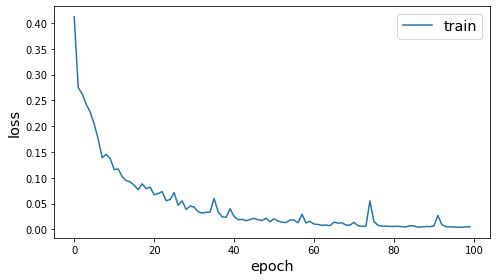

In [34]:
plot_history(history)

In [35]:
x_emb_in, x_emb_out = graphsage_model.in_out_tensors()
# for full batch models, squeeze out the batch dim (which is 1)
if graphsage_generator.num_batch_dims() == 2:
    print("2")
    x_emb_out = tf.squeeze(x_emb_out, axis=0)

emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

In [37]:
node_gen = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5, 5, 5]).flow(G.nodes())
node_embeddings = emb_model.predict(node_gen, workers=4, verbose=1)

211/211 [==============================] - 242s 1s/step


In [38]:
pd.DataFrame(node_embeddings).to_csv("best_emb.csv")

In [24]:
pd.DataFrame(node_embeddings).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.002338,-0.213843,0.010137,-0.028450,0.006746,0.047177,0.076987,-0.034726,-0.013607,-0.008969,0.005453,0.042764,-0.127570,-0.060813,-0.205069,0.006187,-0.006967,0.042522,-0.029246,0.007081,0.013705,0.047252,-0.088825,-0.033271,-0.159286,-0.034756,-0.036575,-0.013160,0.051381,0.007805,0.020794,-0.074186,-0.027249,0.013245,-0.076959,-0.212199,0.022312,0.051649,0.004775,0.023525,-0.005682,0.026609,-0.027189,-0.047381,0.053455,0.011248,0.023457,-0.053407,0.020209,0.019984,0.018017,0.056980,0.039344,-0.023295,0.025407,0.031761,-0.024471,-0.045821,0.031825,0.017782,-0.212559,-0.047726,0.020870,-0.182602,-0.015188,-0.066406,-0.149556,-0.002781,-0.016304,-0.011725,0.003075,-0.033008,0.007626,0.221079,0.063359,-0.105694,-0.002307,0.020209,-0.015000,0.002496,-0.001665,-0.151854,0.111323,-0.000734,0.115533,0.067222,-0.157441,-0.015518,-0.029022,0.136532,-0.189865,0.015947,0.213632,0.005989,0.135832,-0.121423,0.023816,-0.007506,-0.096931,0.136270,0.061279,-0.160116,-0.009681,-0.184406,0.019373,-0.032020,0.124012,0.104287,-0.192470,-0.004725,0.150739,0.028325,-0.198222,-0.041471,0.002549,0.015390,0.022949,-0.150990,-0.032659,-0.010351,-0.153055,-0.144263,-0.058743,-0.154583,-0.035537,-0.177358,-0.114154,0.006289
1,-0.003499,-0.207329,0.006055,-0.007346,0.002577,0.042753,0.073339,-0.037056,-0.009329,-0.018686,0.007166,0.038535,-0.150218,-0.080195,0.002144,0.001304,-0.003476,0.044390,-0.026687,0.006439,0.010862,0.036583,-0.088890,0.005187,-0.153108,-0.043226,-0.048377,-0.010481,0.048558,0.017388,0.016874,-0.109154,-0.035043,0.012821,-0.073077,-0.188261,0.014724,0.045937,0.001210,0.025085,-0.006406,0.024499,-0.023423,-0.057262,0.043050,0.009770,0.023382,-0.052388,0.016205,0.017178,0.015706,0.053915,0.038669,-0.027466,0.017329,0.032088,-0.047288,-0.056313,0.031600,0.014485,-0.197122,-0.049497,0.021712,-0.111827,-0.004847,-0.047638,-0.172800,-0.034637,-0.041619,-0.006857,0.043450,-0.016459,-0.058341,0.257945,-0.046461,-0.032303,0.010646,0.080387,-0.027186,0.007776,-0.030417,-0.175917,0.092988,0.023777,-0.050263,0.045994,-0.155623,-0.022524,-0.006367,-0.135150,-0.167197,0.034512,0.187004,-0.016804,-0.114511,-0.150771,0.028479,-0.017613,-0.071755,0.123514,0.137740,-0.180717,-0.017545,-0.193212,0.022681,-0.015965,0.151612,0.156371,-0.200182,0.013346,0.177793,-0.037692,-0.195612,-0.001913,0.000598,0.006433,0.075959,-0.041263,-0.012866,0.000214,0.066708,-0.210799,-0.085771,-0.195067,0.017457,-0.208052,0.099082,0.082680
2,-0.004116,-0.257037,0.008042,-0.012346,0.003790,0.053099,0.090492,-0.045096,-0.012093,-0.021482,0.008530,0.047897,-0.181337,-0.095616,-0.082423,0.002337,-0.004794,0.054157,-0.033116,0.007993,0.013750,0.046476,-0.109003,0.002316,-0.188719,-0.051763,-0.057607,-0.013260,0.059976,0.019878,0.021286,-0.129289,-0.041825,0.015788,-0.090210,-0.239028,0.019203,0.057199,0.002022,0.030528,-0.007747,0.030363,-0.029298,-0.068780,0.054367,0.012205,0.028687,-0.064401,0.020478,0.021490,0.019610,0.066583,0.047524,-0.033061,0.022471,0.039303,-0.054751,-0.067529,0.038787,0.018261,-0.246485,-0.060437,0.026500,-0.153853,0.001230,0.010162,-0.166314,0.021652,-0.001797,-0.001391,0.038082,0.033703,0.009489,0.223447,-0.058192,0.005109,0.001417,0.073571,-0.002714,0.014159,-0.003936,-0.170199,0.066632,-0.027732,0.027306,0.031361,-0.106613,0.000299,0.041450,0.040789,-0.143480,0.034144,0.202909,-0.049842,0.034879,-0.134209,0.103965,-0.006506,-0.032863,0.090741,0.071705,-0.169929,-0.004984,-0.203166,0.025326,0.034486,0.144112,0.050968,-0.216601,0.008743,0.140243,-0.044132,-0.161597,-0.021192,-0.011844,0.001967,0.052652,-0.016394,0.040037,0.000904,-0.131935,-0.23315

In [29]:
node_data.shape

(210392, 54)

In [30]:
node_embeddings.shape

(210392, 128)